adding header to the data files:

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import ast
from collections import defaultdict
from matplotlib.gridspec import GridSpec
import cpi

# Define the column names
movie_header = [
    "Wikipedia movie ID", "Freebase movie ID", "Name", 
    "Release date", "Box office revenue", 
    "Runtime", "Languages", "Countries", "Genres"
]
characters_header = [
    "Wikipedia movie ID", "Freebase movie ID", "Release date", 
    "Character name", "Actor date of birth", "Actor gender", 
    "Actor height(meters)", "Actor ethnicity", "Actor name", 
    "Actor age at release", "Freebase character/actor map ID", 
    "Freebase character ID", "Freebase actor ID"
]

# Read the TSV file without headers
movies = pd.read_csv("../../data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, names=movie_header)
characters = pd.read_csv("../../data/MovieSummaries/character.metadata.tsv", sep='\t', header=None, names=characters_header)
summaries = pd.read_csv("../../data/MovieSummaries/plot_summaries.txt", sep='\t', header=None, names=['Wikipedia movie ID', 'Summary'])

# Save the file with headers
movies.to_csv("../../data/MovieSummaries/movie.metadata.tsv", sep='\t', index=False)
characters.to_csv("../../data/MovieSummaries/character.metadata.tsv", sep='\t', index=False)
summaries.to_csv("../../data/MovieSummaries/plot_summaries.txt", sep='\t', index=False)


/tmp/ipykernel_67671/2615280943.py:26: DtypeWarning: Columns (0,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("../../data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, names=movie_header)
/tmp/ipykernel_67671/2615280943.py:27: DtypeWarning: Columns (0,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  characters = pd.read_csv("../../data/MovieSummaries/character.metadata.tsv", sep='\t', header=None, names=characters_header)


=== Data Quality Check ===

Runtime dtype: float64
Box office dtype: float64
Release date dtype: datetime64[ns]

=== Basic Statistics ===

Runtime Statistics (in minutes):
count    6.129100e+04
mean     1.118192e+02
std      4.360070e+03
min      0.000000e+00
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Runtime, dtype: float64

Box Office Statistics (inflation-adjusted, in millions USD):
count    6793.000000
mean      119.721910
std       288.628816
min         0.013974
25%        11.213742
50%        35.853781
75%       115.564896
max      8802.502222
Name: Adjusted_Revenue, dtype: float64


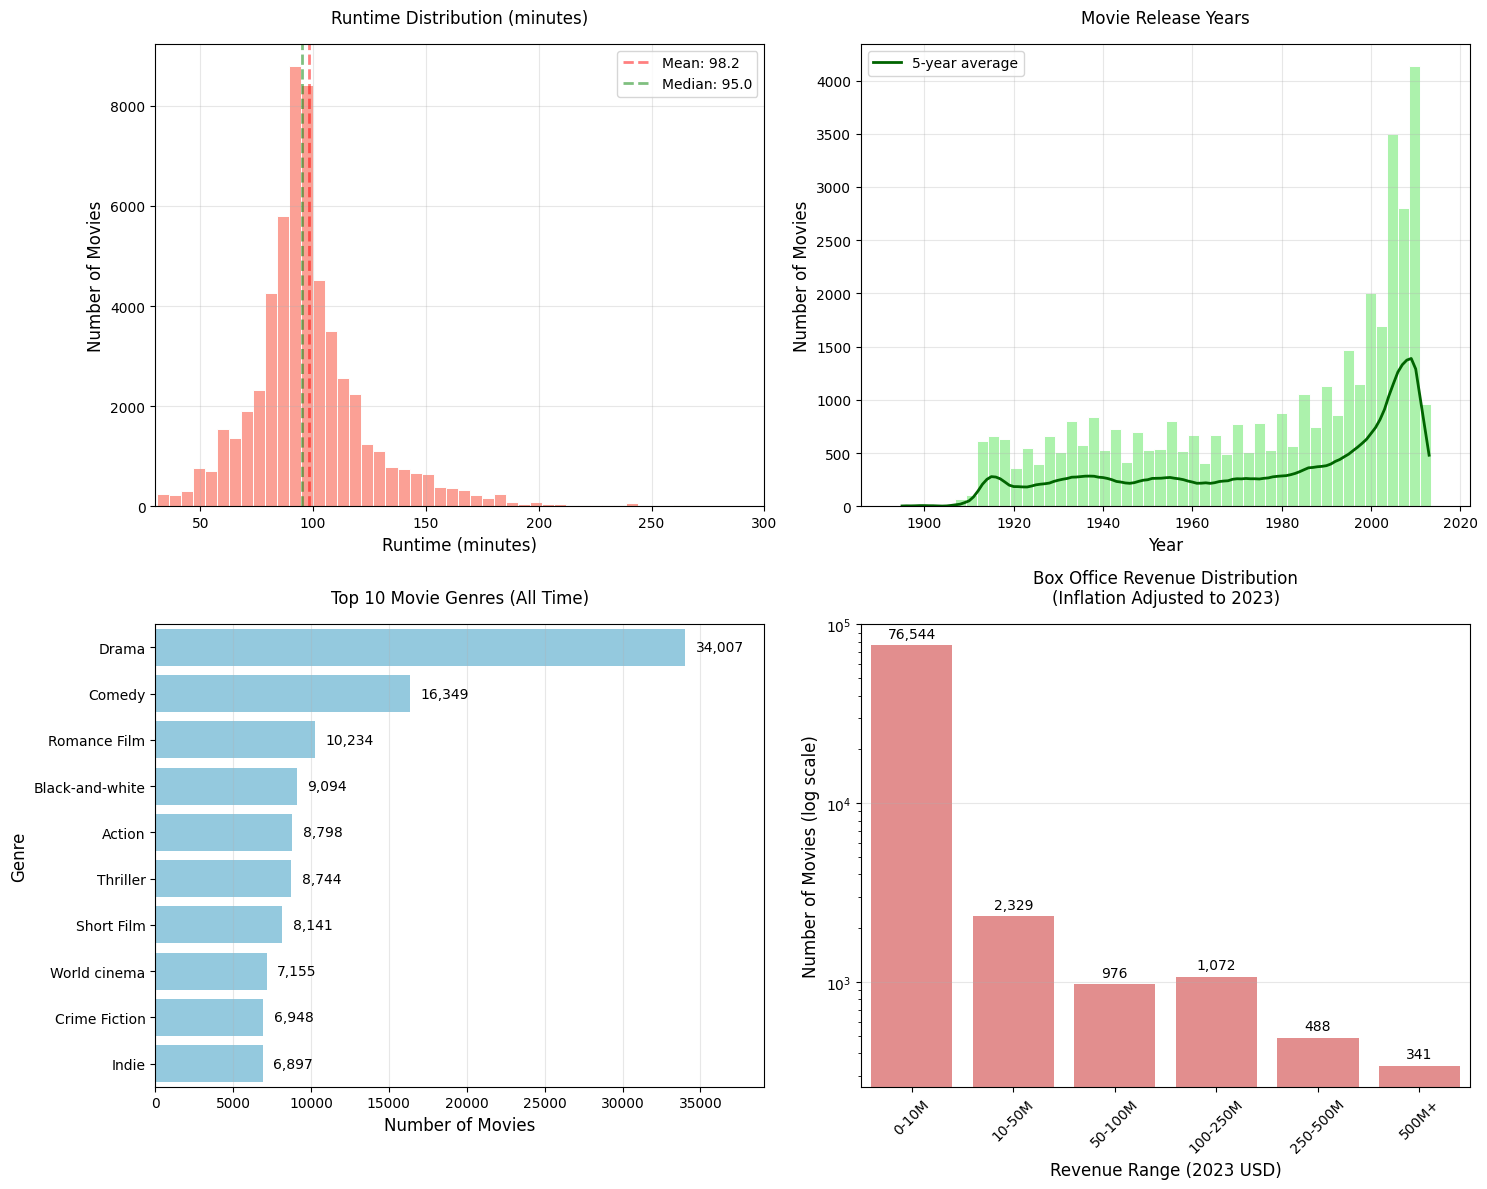


=== Anomaly Detection ===

Movies with unusual runtimes (<60 or >240 minutes): 7013

Sample of unusual runtime movies:
                             Name  Runtime
14                  The Gangsters     35.0
34                 Camera Thrills     25.0
55                         Troops     10.0
79  Bruce Lee: The Lost Interview     30.0
94              The Covered Wagon     23.0

Top 1% box office movies count (inflation-adjusted): 68

Top 5 highest grossing movies (inflation-adjusted):
                                  Name  Adjusted_Revenue  Box office revenue  \
12109  Snow White and the Seven Dwarfs      8.802502e+09        4.160000e+08   
37843               Gone with the Wind      8.768403e+09        4.000000e+08   
1262                             Bambi      4.999490e+09        2.674472e+08   
22265                          Titanic      4.148831e+09        2.185372e+09   
7126     Love with the Proper Stranger      4.132445e+09        4.150049e+08   

       Release Year  
12109    

(       Wikipedia movie ID  Freebase movie ID  \
 0      Wikipedia movie ID  Freebase movie ID   
 1      Wikipedia movie ID  Freebase movie ID   
 2      Wikipedia movie ID  Freebase movie ID   
 3      Wikipedia movie ID  Freebase movie ID   
 4      Wikipedia movie ID  Freebase movie ID   
 ...                   ...                ...   
 81745            35228177         /m/0j7hxnt   
 81746            34980460         /m/0g4pl34   
 81747             9971909         /m/02pygw1   
 81748              913762          /m/03pcrp   
 81749            12476867         /m/02w7zz8   
 
                                                     Name Release date  \
 0                                                   Name          NaT   
 1                                                   Name          NaT   
 2                                                   Name          NaT   
 3                                                   Name          NaT   
 4                                      

In [16]:
def clean_movie_data(movies, characters, summaries):
    """
    Clean the movie dataset before analysis
    """
    movies_clean = movies.copy()
    
    # Convert Runtime to numeric, coercing errors to NaN
    movies_clean['Runtime'] = pd.to_numeric(movies_clean['Runtime'], errors='coerce')
    
    # Convert Box office revenue to numeric
    movies_clean['Box office revenue'] = pd.to_numeric(movies_clean['Box office revenue'], errors='coerce')
    
    # Convert Release date to datetime with specific format
    movies_clean['Release date'] = pd.to_datetime(movies_clean['Release date'], format='%Y-%m-%d', errors='coerce')
    
    # Simplified genre cleaning
    def clean_genre(genre_string):
        if pd.isna(genre_string):
            return []
        # Remove common special characters and split on commas
        cleaned = (genre_string.replace('{', '')
                             .replace('}', '')
                             .replace('"', ''))
        genres = [g.split(':')[-1].strip() for g in cleaned.split(',')]
        # Remove empty strings and duplicates
        return list(set(genre for genre in genres if genre))
    
    # Apply genre cleaning
    movies_clean['Genres_clean'] = movies_clean['Genres'].apply(clean_genre)
    
    return movies_clean, characters, summaries

def get_top_10_genres(movies):
    """
    Calculate the top 10 genres across all years consistently
    """
    all_genres = []
    for genre_list in movies['Genres_clean']:
        all_genres.extend(genre_list)
    return pd.Series(all_genres).value_counts().head(10).index.tolist()

def adjust_for_inflation(df):
    """
    Adjust revenue values for inflation
    """
    current_year = 2023  # Using current year for inflation adjustment
    min_cpi_year = 1913  # Oldest year available in CPI data
    
    # Create inflation factors dictionary with fallback to min_cpi_year
    inflation_factors = {}
    for year in df['Release Year'].unique():
        if pd.isna(year):
            continue
        try:
            year = int(year)
            if year < min_cpi_year:
                # Use 1913 as base year if movie is older
                inflation_factors[year] = cpi.inflate(1.0, min_cpi_year, to=current_year)
            else:
                inflation_factors[year] = cpi.inflate(1.0, year, to=current_year)
        except:
            inflation_factors[year] = np.nan
            
    # Apply inflation adjustment
    df['Inflation_Multiplier'] = df['Release Year'].map(inflation_factors)
    df['Adjusted_Revenue'] = df['Box office revenue'] * df['Inflation_Multiplier']
    return df

def analyze_movie_dataset(movies, characters, summaries):
    """
    Enhanced analysis of the CMU Movie Summary dataset with consistent genre handling
    """
    # Clean the data first
    movies, characters, summaries = clean_movie_data(movies, characters, summaries)
    
    # Get top 10 genres once for consistency
    all_genres = []
    for genre_list in movies['Genres_clean']:
        all_genres.extend(genre_list)
    top_10_genres = get_top_10_genres(movies)
    genre_counts = pd.Series(all_genres).value_counts()
    
    # Add Release Year for inflation adjustment
    movies['Release Year'] = movies['Release date'].dt.year
    
    # Adjust box office revenue for inflation
    movies_with_inflation = adjust_for_inflation(movies.copy())
    
    print("=== Data Quality Check ===")
    print(f"\nRuntime dtype: {movies['Runtime'].dtype}")
    print(f"Box office dtype: {movies['Box office revenue'].dtype}")
    print(f"Release date dtype: {movies['Release date'].dtype}")
    
    # 1. Basic Statistics
    print("\n=== Basic Statistics ===")
    
    print("\nRuntime Statistics (in minutes):")
    runtime_stats = movies['Runtime'].describe()
    print(runtime_stats)
    
    print("\nBox Office Statistics (inflation-adjusted, in millions USD):")
    box_office_millions = movies_with_inflation['Adjusted_Revenue'] / 1_000_000
    print(box_office_millions.describe())
    
    # 2. Visualizations with improvements
    plt.figure(figsize=(15, 12))
    
    # Runtime Distribution
    plt.subplot(2, 2, 1)
    valid_runtimes = movies['Runtime'].dropna()
    valid_runtimes = valid_runtimes[
        (valid_runtimes > 30) &  
        (valid_runtimes < 300)   
    ]
    sns.histplot(data=valid_runtimes, bins=50, color='salmon', edgecolor='white')
    plt.title('Runtime Distribution (minutes)', pad=15, fontsize=12)
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Number of Movies')
    plt.xlim(30, 300)
    
    # Add mean and median lines
    plt.axvline(valid_runtimes.mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: {valid_runtimes.mean():.1f}')
    plt.axvline(valid_runtimes.median(), color='green', linestyle='--', alpha=0.5, label=f'Median: {valid_runtimes.median():.1f}')
    plt.legend()
    
    # Release Year Distribution
    plt.subplot(2, 2, 2)
    year_data = movies['Release Year'].dropna()
    sns.histplot(data=year_data, bins=50, color='lightgreen', edgecolor='white')
    plt.title('Movie Release Years', pad=15, fontsize=12)
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    
    # Add rolling average line
    year_counts = pd.Series(year_data).value_counts().sort_index()
    year_counts_smooth = year_counts.rolling(window=5, center=True).mean()
    plt.plot(year_counts_smooth.index, year_counts_smooth.values, color='darkgreen', label='5-year average')
    plt.legend()
    
    # Genre Distribution (top 10)
    plt.subplot(2, 2, 3)
    
    # Use the pre-calculated top 10 genres
    top_10_counts = genre_counts[top_10_genres]
    
    # Calculate figure size and adjust margins
    fig = plt.gcf()
    fig.subplots_adjust(left=0.2)
    
    # Create genre plot
    genre_df = pd.DataFrame({'Genre': top_10_counts.index, 'Count': top_10_counts.values})
    ax = sns.barplot(data=genre_df, y='Genre', x='Count', color='skyblue')
    plt.title('Top 10 Movie Genres (All Time)', pad=15, fontsize=12)
    plt.xlabel('Number of Movies')
    
    # Add value labels
    for i, v in enumerate(top_10_counts.values):
        ax.text(v + (top_10_counts.max() * 0.02), i, f'{v:,}', va='center')
    
    plt.xlim(0, top_10_counts.max() * 1.15)
    
    # Box Office Revenue Analysis (Inflation Adjusted)
    plt.subplot(2, 2, 4)
    
    # Create revenue brackets (inflation-adjusted)
    revenue_bins = [0, 10, 50, 100, 250, 500, float('inf')]
    revenue_labels = ['0-10M', '10-50M', '50-100M', '100-250M', '250-500M', '500M+']
    
    # Convert to millions and categorize using inflation-adjusted revenue
    movies_with_inflation['Revenue_Category'] = pd.cut(
        movies_with_inflation['Adjusted_Revenue'].fillna(0) / 1_000_000,
        bins=revenue_bins,
        labels=revenue_labels,
        right=False
    )
    
    # Count movies in each category
    revenue_dist = movies_with_inflation['Revenue_Category'].value_counts().sort_index()
    
    # Create revenue distribution plot
    revenue_df = pd.DataFrame({'Category': revenue_dist.index, 'Count': revenue_dist.values})
    ax = sns.barplot(data=revenue_df, x='Category', y='Count', color='lightcoral')
    plt.yscale('log')
    plt.title('Box Office Revenue Distribution\n(Inflation Adjusted to 2023)', pad=15, fontsize=12)
    plt.xlabel('Revenue Range (2023 USD)')
    plt.ylabel('Number of Movies (log scale)')
    plt.xticks(rotation=45)
    
    # Add value labels
    for i, v in enumerate(revenue_dist.values):
        ax.text(i, v * 1.1, f'{v:,}', ha='center', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Anomaly Detection
    print("\n=== Anomaly Detection ===")
    
    # Runtime anomalies
    runtime_anomalies = movies[
        (movies['Runtime'].notna()) & 
        ((movies['Runtime'] < 60) | (movies['Runtime'] > 240))
    ]
    print(f"\nMovies with unusual runtimes (<60 or >240 minutes): {len(runtime_anomalies)}")
    if len(runtime_anomalies) > 0:
        print("\nSample of unusual runtime movies:")
        print(runtime_anomalies[['Name', 'Runtime']].head())
    
    # Box office anomalies (using inflation-adjusted values)
    box_office_anomalies = movies_with_inflation[
        (movies_with_inflation['Adjusted_Revenue'].notna()) & 
        (movies_with_inflation['Adjusted_Revenue'] > box_office_millions.quantile(0.99) * 1_000_000)
    ]
    print(f"\nTop 1% box office movies count (inflation-adjusted): {len(box_office_anomalies)}")
    if len(box_office_anomalies) > 0:
        print("\nTop 5 highest grossing movies (inflation-adjusted):")
        print(box_office_anomalies.nlargest(5, 'Adjusted_Revenue')[['Name', 'Adjusted_Revenue', 'Box office revenue', 'Release Year']])
    
    # 4. Dataset Coverage
    print("\n=== Dataset Coverage ===")
    total_movies = len(movies)
    print(f"\nTotal number of movies: {total_movies}")
    print(f"Movies with runtime data: {movies['Runtime'].notna().sum()} ({(movies['Runtime'].notna().sum()/total_movies*100):.1f}%)")
    print(f"Movies with box office data: {movies['Box office revenue'].notna().sum()} ({(movies['Box office revenue'].notna().sum()/total_movies*100):.1f}%)")
    print(f"Movies with genre data: {movies['Genres'].notna().sum()} ({(movies['Genres'].notna().sum()/total_movies*100):.1f}%)")
    
    # 5. Genre Analysis
    print("\n=== Genre Analysis ===")
    print("\nTop 20 Genres:")
    print(genre_counts.head(20))
    
    # Average runtime and inflation-adjusted box office by genre
    genre_stats = []
    for genre in top_10_genres:
        movies_in_genre = movies_with_inflation[movies_with_inflation['Genres_clean'].apply(lambda x: genre in x)]
        avg_runtime = movies_in_genre['Runtime'].mean()
        avg_boxoffice = movies_in_genre['Adjusted_Revenue'].mean() / 1_000_000
        genre_stats.append({
            'Genre': genre,
            'Movie Count': len(movies_in_genre),
            'Avg Runtime': round(avg_runtime, 1) if not pd.isna(avg_runtime) else None,
            'Avg Box Office (M, 2023 USD)': round(avg_boxoffice, 1) if not pd.isna(avg_boxoffice) else None
        })
    
    print("\nStatistics for top 10 genres (with inflation-adjusted revenue):")
    print(pd.DataFrame(genre_stats))
    
    # Additional Revenue Analysis
    print("\n=== Revenue Distribution (Inflation Adjusted) ===")
    revenue_distribution = movies_with_inflation['Revenue_Category'].value_counts().sort_index()
    print("\nMovies by Revenue Category (2023 USD):")
    for category, count in revenue_distribution.items():
        total = len(movies)
        percentage = (count/total) * 100
        print(f"{category}: {count:,} movies ({percentage:.1f}%)")
        
    return movies, characters, summaries

# Run the analysis
analyze_movie_dataset(movies, characters, summaries)

Starting data preparation...
Creating visualizations...
Analyzing genre evolution...
Analyzing runtime trends...
Analyzing box office trends...
Analyzing gender distribution...
Analyzing age distribution...


/tmp/ipykernel_67671/2466381686.py:325: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_by_year = valid_age.groupby(['Year', 'Age Category'])['Freebase character ID'].count().unstack(fill_value=0)


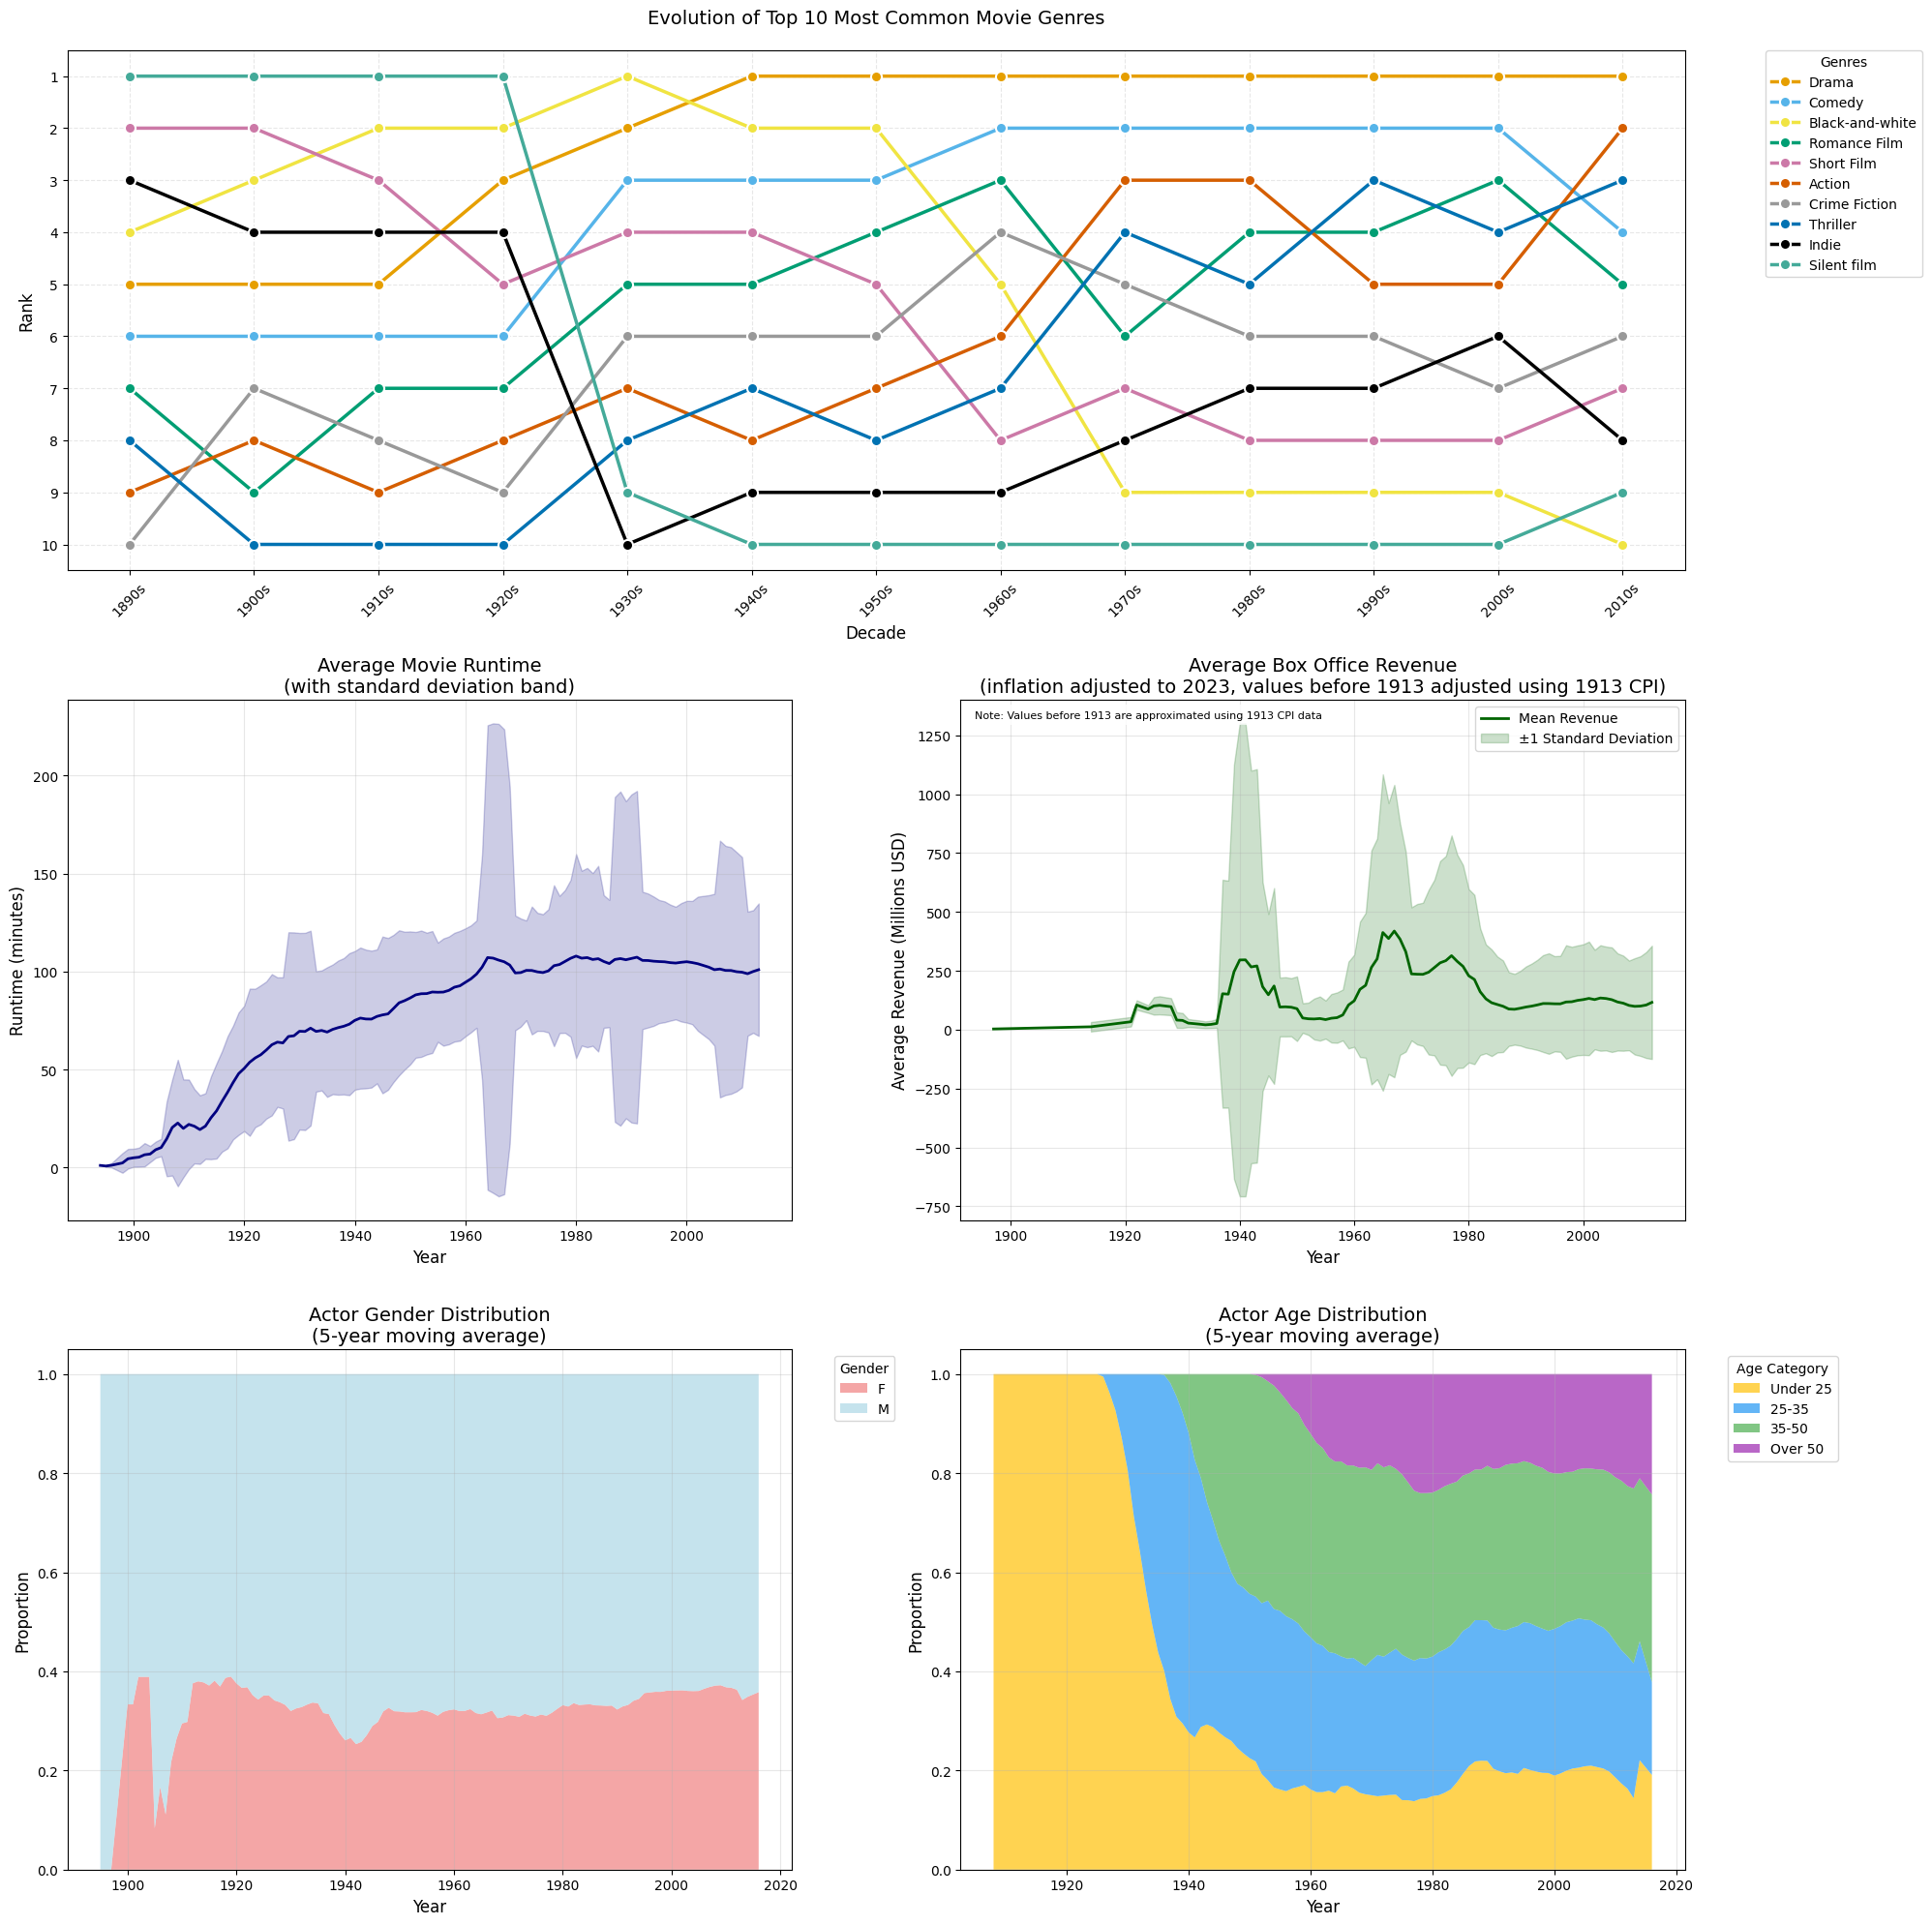


=== Key Insights ===

Runtime comparison:
Pre-1950 average runtime: 69.3 minutes
Post-2000 average runtime: 100.6 minutes

Actor gender diversity evolution:

Gender distribution (Recent vs Early):
Recent years (2000+):
Actor gender
M    0.647
F    0.353
Name: proportion, dtype: float64

Early years (pre-1950):
Actor gender
M    0.682
F    0.318
Name: proportion, dtype: float64

Actor age distribution:

Recent years (2000+):
Age Category
35-50       0.325
25-35       0.277
Over 50     0.218
Under 25    0.179
Name: proportion, dtype: float64

Early years (pre-1950):
Age Category
25-35       0.424
Under 25    0.369
35-50       0.207
Over 50     0.000
Name: proportion, dtype: float64


(      Wikipedia movie ID Freebase movie ID  \
 9                 975900         /m/03vyhn   
 10               3196793         /m/08yl5d   
 14              13696889        /m/03cfc81   
 16              10408933        /m/02qc0j7   
 21               6631279         /m/0gffwj   
 ...                  ...               ...   
 81744           32468537        /m/0crwd9y   
 81745           35228177        /m/0j7hxnt   
 81746           34980460        /m/0g4pl34   
 81747            9971909        /m/02pygw1   
 81748             913762         /m/03pcrp   
 
                                                     Name Release date  \
 9                                         Ghosts of Mars   2001-08-24   
 10     Getting Away with Murder: The JonBenét Ramsey ...   2000-02-16   
 14                                         The Gangsters   1913-05-29   
 16                              Alexander's Ragtime Band   1938-08-16   
 21                                           Little city   1997

In [18]:
def clean_date_column(df, date_column='Release date'):
    """
    Clean the release date column by removing invalid entries and converting to datetime
    """
    df = df.copy()
    df[date_column] = df[date_column].replace('Release date', np.nan)
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    df['Year'] = df[date_column].dt.year
    return df

def clean_age_column(df, age_column='Actor age at release'):
    """
    Clean the age column by converting to numeric, handling invalid values
    """
    df = df.copy()
    df[age_column] = pd.to_numeric(df[age_column], errors='coerce')
    return df

def create_genre_evolution_plot(movies, ax, decade_interval=10):
    """
    Create an improved visualization of genre evolution over time focusing on the top 10 genres of all time,
    showing their relative rankings within each decade
    """
    # Calculate top 10 genres across all years
    top_10_genres = get_top_10_genres(movies)
    
    # Create yearly genre counts
    genre_by_year = defaultdict(lambda: defaultdict(int))
    for _, movie in movies.iterrows():
        year = movie['Year']
        if pd.notna(year) and movie['Genres_clean']:
            genres = [str(genre).strip() for genre in movie['Genres_clean']]
            for genre in genres:
                if genre in top_10_genres:  # Only count top 10 genres
                    genre_by_year[year][genre] += 1
    
    # Convert to DataFrame
    genre_df = pd.DataFrame.from_dict(genre_by_year, orient='index').fillna(0)
    
    if genre_df.empty:
        print("No valid genre data found")
        return
    
    # Get the range of years and create decade markers
    min_year = int(genre_df.index.min())
    max_year = int(genre_df.index.max())
    
    # Create decade bins
    decades = range(
        (min_year // decade_interval) * decade_interval,
        (max_year // decade_interval + 1) * decade_interval + 1,
        decade_interval
    )
    
    # Calculate rankings for each decade
    decade_rankings = []
    for start_decade in decades[:-1]:
        end_decade = start_decade + decade_interval
        decade_slice = genre_df[
            (genre_df.index >= start_decade) & 
            (genre_df.index < end_decade)
        ]
        
        if not decade_slice.empty:
            # Sum counts for the decade
            decade_sums = decade_slice.sum()
            # Get counts for top 10 genres
            genre_counts = {genre: decade_sums.get(genre, 0) for genre in top_10_genres}
            # Sort genres by count and assign rankings
            sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
            rankings = {genre: rank + 1 for rank, (genre, _) in enumerate(sorted_genres)}
            # Store results
            decade_rankings.append({
                'decade': start_decade,
                'rankings': rankings
            })
    
    # Define a color-blind friendly palette
    colors = [
        '#E69F00',  # Orange
        '#56B4E9',  # Light blue
        '#009E73',  # Green
        '#F0E442',  # Yellow
        '#0072B2',  # Dark blue
        '#D55E00',  # Red
        '#CC79A7',  # Pink
        '#000000',  # Black
        '#999999',  # Gray
        '#44AA99'   # Teal
    ]
    
    # Create color dictionary for genres
    color_dict = dict(zip(top_10_genres, colors))
    
    # Plot lines for each genre
    decades_list = [d['decade'] for d in decade_rankings]
    
    # Calculate average ranking for legend ordering
    genre_avg_rankings = {}
    for genre in top_10_genres:
        rankings = [d['rankings'][genre] for d in decade_rankings]
        genre_avg_rankings[genre] = sum(rankings) / len(rankings)
    
    # Sort genres by average ranking (lower ranking = higher average position)
    sorted_genres = sorted(top_10_genres, 
                         key=lambda x: genre_avg_rankings[x])
    
    # Plot with improved visibility
    for genre in sorted_genres:
        rankings = [d['rankings'][genre] for d in decade_rankings]
        
        # Plot line
        ax.plot(decades_list, rankings,
                '-o',  # Line with circles at data points
                color=color_dict[genre],
                linewidth=2.5,
                markersize=8,
                label=genre,
                markeredgecolor='white',
                markeredgewidth=1.5)
    
    # Customize the plot
    ax.set_xlim(min(decades_list) - 5, max(decades_list) + 5)
    ax.set_ylim(10.5, 0.5)  # Reversed y-axis to show rank 1 at the top
    
    # Add labels and title
    ax.set_title('Evolution of Top 10 Most Common Movie Genres', pad=20, fontsize=14)
    ax.set_xlabel('Decade', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)
    
    # Customize grid
    ax.grid(True, linestyle='--', alpha=0.3, zorder=1)
    
    # Improve x-axis ticks
    ax.set_xticks(decades_list)
    ax.set_xticklabels([f'{year}s' for year in decades_list])
    
    # Customize y-axis ticks
    ax.set_yticks(range(1, 11))
    ax.set_yticklabels(range(1, 11))
    
    # Add legend with better positioning
    ax.legend(title='Genres',
             bbox_to_anchor=(1.05, 1),
             loc='upper left',
             borderaxespad=0.,
             frameon=True,
             fontsize=10)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45)


def create_revenue_plot(movies, ax):
    """
    Create improved box office revenue plot with CPI inflation adjustment and deviation band
    Optimized version using vectorized operations with fallback for old years
    """
    valid_revenue = movies[movies['Box office revenue'].notna()].copy()
    current_year = 2023  # Using current year for inflation adjustment
    min_cpi_year = 1913  # Oldest year available in CPI data
    
    # Ensure Year is integer for CPI calculation
    valid_revenue['Year'] = valid_revenue['Year'].astype(int)
    
    # Get all unique years and adjust those before min_cpi_year
    unique_years = valid_revenue['Year'].unique()
    
    # Create inflation factors dictionary with fallback to min_cpi_year
    inflation_factors = {}
    for year in unique_years:
        try:
            inflation_factors[year] = cpi.inflate(1.0, int(year), to=int(current_year))
        except:
            # If year is too old, use min_cpi_year as base
            if year < min_cpi_year:
                try:
                    # Adjust using oldest available CPI data
                    inflation_factors[year] = cpi.inflate(1.0, min_cpi_year, to=int(current_year))
                except:
                    # If still fails, mark for removal
                    inflation_factors[year] = np.nan
            else:
                # If year is in range but still fails, mark for removal
                inflation_factors[year] = np.nan
    
    # Create a vectorized inflation factor array
    inflation_multipliers = valid_revenue['Year'].map(inflation_factors)
    
    # Adjust revenues for inflation using vectorized operation
    valid_revenue['Adjusted_Revenue'] = valid_revenue['Box office revenue'] * inflation_multipliers
    
    # Remove any rows where inflation adjustment failed
    valid_revenue = valid_revenue[valid_revenue['Adjusted_Revenue'].notna()]
    
    if valid_revenue.empty:
        print("No valid revenue data after inflation adjustment")
        return
    
    # Calculate yearly statistics
    yearly_stats = valid_revenue.groupby('Year')['Adjusted_Revenue'].agg(['mean', 'std']).rolling(window=5, min_periods=1).mean()
    yearly_stats['mean'] = yearly_stats['mean'] / 1_000_000  # Convert to millions
    yearly_stats['std'] = yearly_stats['std'] / 1_000_000    # Convert to millions
    
    # Plot mean line
    ax.plot(yearly_stats.index, yearly_stats['mean'], 
            color='darkgreen', linewidth=2, label='Mean Revenue')
    
    # Add deviation band
    ax.fill_between(yearly_stats.index,
                   yearly_stats['mean'] - yearly_stats['std'],
                   yearly_stats['mean'] + yearly_stats['std'],
                   alpha=0.2, color='darkgreen', label='±1 Standard Deviation')
    
    ax.set_title(f'Average Box Office Revenue\n(inflation adjusted to {current_year}, values before {min_cpi_year} adjusted using {min_cpi_year} CPI)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Revenue (Millions USD)')
    ax.legend()

    # Add note about data adjustment if there are early years
    if valid_revenue['Year'].min() < min_cpi_year:
        ax.text(0.02, 0.98, f'Note: Values before {min_cpi_year} are approximated using {min_cpi_year} CPI data',
                transform=ax.transAxes, fontsize=8, verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
def analyze_temporal_trends(movies, characters, summaries):
    """
    Analyze temporal trends in the CMU Movie Dataset
    """
    print("Starting data preparation...")
    
    # Clean and prepare the data
    movies, characters, summaries = clean_movie_data(movies, characters, summaries)
    
    # Clean date columns and add year
    movies = clean_date_column(movies)
    characters = clean_date_column(characters)
    
    # Clean age data
    characters = clean_age_column(characters)
    
    # Remove rows with invalid dates
    movies = movies[movies['Year'].notna()]
    characters = characters[characters['Year'].notna()]
    
    # Ensure Genres_clean is a list of strings
    movies['Genres_clean'] = movies['Genres_clean'].apply(lambda x: [str(genre).strip() for genre in (x or [])])
    
    # Create Age Category for the main dataframe
    age_bins = [-np.inf, 25, 35, 50, np.inf]
    age_labels = ['Under 25', '25-35', '35-50', 'Over 50']
    characters['Age Category'] = pd.cut(characters['Actor age at release'],
                                      bins=age_bins,
                                      labels=age_labels)
    
    # Set style parameters
    plt.rcParams['figure.figsize'] = (20, 20)
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['figure.titlesize'] = 16
    plt.rcParams['lines.linewidth'] = 2
    
    # Create figure with custom layout
    fig = plt.figure()
    gs = GridSpec(3, 2, figure=fig)
    
    print("Creating visualizations...")
    
    # 1. Genre Evolution (Improved)
    print("Analyzing genre evolution...")
    ax1 = fig.add_subplot(gs[0, :])
    create_genre_evolution_plot(movies, ax1)
    
    # 2. Movie Runtime Trends
    print("Analyzing runtime trends...")
    ax2 = fig.add_subplot(gs[1, 0])
    
    yearly_runtime = movies[movies['Runtime'].notna()].groupby('Year')['Runtime'].agg(['mean', 'std']).rolling(window=5, min_periods=1).mean()
    
    ax2.plot(yearly_runtime.index, yearly_runtime['mean'], color='navy', linewidth=2)
    ax2.fill_between(yearly_runtime.index,
                     yearly_runtime['mean'] - yearly_runtime['std'],
                     yearly_runtime['mean'] + yearly_runtime['std'],
                     alpha=0.2, color='navy')
    
    ax2.set_title('Average Movie Runtime\n(with standard deviation band)')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Runtime (minutes)')
    
    # 3. Box Office Trends (Improved)
    print("Analyzing box office trends...")
    ax3 = fig.add_subplot(gs[1, 1])
    create_revenue_plot(movies, ax3)
    
    # 4. Gender Distribution
    print("Analyzing gender distribution...")
    ax4 = fig.add_subplot(gs[2, 0])
    
    valid_gender = characters[characters['Actor gender'].notna()]
    gender_by_year = valid_gender.groupby(['Year', 'Actor gender'])['Freebase character ID'].count().unstack(fill_value=0)
    gender_proportions = gender_by_year.div(gender_by_year.sum(axis=1), axis=0)
    gender_proportions_smooth = gender_proportions.rolling(window=5, min_periods=1).mean()
    
    colors = ['lightcoral', 'lightblue']  # Simple color scheme for gender
    
    ax4.stackplot(gender_proportions_smooth.index, 
                 gender_proportions_smooth.T.values,
                 labels=gender_proportions_smooth.columns,
                 colors=colors,
                 alpha=0.7)
    
    ax4.set_title('Actor Gender Distribution\n(5-year moving average)')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Proportion')
    ax4.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 5. Age Distribution
    print("Analyzing age distribution...")
    ax5 = fig.add_subplot(gs[2, 1])
    
    valid_age = characters[characters['Actor age at release'].notna()].copy()
    age_by_year = valid_age.groupby(['Year', 'Age Category'])['Freebase character ID'].count().unstack(fill_value=0)
    age_proportions = age_by_year.div(age_by_year.sum(axis=1), axis=0)
    age_proportions_smooth = age_proportions.rolling(window=5, min_periods=1).mean()
    
    age_colors = ['#FFC107', '#2196F3', '#4CAF50', '#9C27B0']  # Custom colors for age groups
    
    ax5.stackplot(age_proportions_smooth.index,
                 age_proportions_smooth.T.values,
                 labels=age_proportions_smooth.columns,
                 colors=age_colors,
                 alpha=0.7)
    
    ax5.set_title('Actor Age Distribution\n(5-year moving average)')
    ax5.set_xlabel('Year')
    ax5.set_ylabel('Proportion')
    ax5.legend(title='Age Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\n=== Key Insights ===")
    
    # Runtime trends
    early_runtime = movies[movies['Year'] < 1950]['Runtime'].mean()
    modern_runtime = movies[movies['Year'] >= 2000]['Runtime'].mean()
    print(f"\nRuntime comparison:")
    print(f"Pre-1950 average runtime: {early_runtime:.1f} minutes")
    print(f"Post-2000 average runtime: {modern_runtime:.1f} minutes")
    
    # Actor gender diversity
    print("\nActor gender diversity evolution:")
    recent_years = characters[characters['Year'] >= 2000].copy()
    early_years = characters[characters['Year'] < 1950].copy()
    
    print("\nGender distribution (Recent vs Early):")
    print("Recent years (2000+):")
    print(recent_years['Actor gender'].value_counts(normalize=True).round(3))
    print("\nEarly years (pre-1950):")
    print(early_years['Actor gender'].value_counts(normalize=True).round(3))
    
    # Actor age distribution
    print("\nActor age distribution:")
    print("\nRecent years (2000+):")
    print(recent_years['Age Category'].value_counts(normalize=True).round(3))
    print("\nEarly years (pre-1950):")
    print(early_years['Age Category'].value_counts(normalize=True).round(3))

    return movies, characters, summaries


analyze_temporal_trends(movies, characters, summaries)